In [29]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [31]:
df = pd.read_csv('D:/Files/GOOG-year.csv')
df.head()

Date        Open        High         Low       Close   Adj Close   
0  2016-11-02  778.200012  781.650024  763.450012  768.700012  768.700012  \
1  2016-11-03  767.250000  769.950012  759.030029  762.130005  762.130005   
2  2016-11-04  750.659973  770.359985  750.560974  762.020020  762.020020   
3  2016-11-07  774.500000  785.190002  772.549988  782.520020  782.520020   
4  2016-11-08  783.400024  795.632996  780.190002  790.510010  790.510010   

    Volume  
0  1872400  
1  1943200  
2  2134800  
3  1585100  
4  1350800

In [32]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.112708
1  0.090008
2  0.089628
3  0.160459
4  0.188066

## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [33]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [34]:
class Model(tf.keras.Model):
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias=0.1):
        super(Model, self).__init__()
        self.size_layer = size_layer
        self.num_layers = num_layers
        self.output_size = output_size
        self.forget_bias = forget_bias

        # Define LSTM layers
        self.lstm_layers = [tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') for _ in range(num_layers)]
        
        # Define dropout layer
        self.dropout = tf.keras.layers.Dropout(1 - forget_bias)
        
        # Dense layer to output the final result
        self.dense = tf.keras.layers.Dense(output_size)

    def call(self, inputs, initial_states=None):
        x = inputs
        for i in range(self.num_layers):
            # Apply LSTM layer
            x, state_h, state_c = self.lstm_layers[i](x, initial_state=initial_states[i] if initial_states is not None else None)
            # Apply dropout after each LSTM layer except for the last one
            if i < self.num_layers - 1:
                x = self.dropout(x)
        # Output layer
        x = self.dense(x[:, -1, :]) # Assuming we're only interested in the last output for generating the next sequence
        return x

In [35]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [36]:
def forecast(model, df, df_log, df_train, epoch, timestamp, test_size, learning_rate, num_layers, size_layer, dropout_rate):
    # Ensure the model is compiled
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        total_loss = []
        total_acc = []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
            batch_y = df_train.iloc[k+1:index+1, :].values
            # Use GradientTape for training
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)  # assuming the call method is appropriately defined
                loss = tf.keras.losses.mean_squared_error(batch_y, predictions)
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            total_loss.append(loss.numpy().mean())  # Assuming calculate_accuracy is defined elsewhere
            total_acc.append(calculate_accuracy(batch_y[:, 0], predictions[:, 0].numpy()))
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
    
    # For forecasting beyond the known dataset
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    for i in range(df_train.shape[0] + future_day):
        if i >= df_train.shape[0]:
            batch_x = output_predict[i-timestamp:i].reshape((1, timestamp, df_train.shape[1]))
            output_predict[i] = model.predict(batch_x)[0]
        else:
            if i % timestamp == 0:
                batch_x = df_train.iloc[i:i+timestamp].values.reshape((1, timestamp, df_train.shape[1]))
                output_predict[i:i+timestamp] = model.predict(batch_x).reshape((timestamp, df_train.shape[1]))
    
    # Inverse transform if needed and calculate the final forecast
    output_predict = MinMaxScaler().inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)  # Assuming anchor is defined elsewhere
    
    return deep_future[-test_size:]

In [40]:
model = Model(
    learning_rate=learning_rate,
    num_layers=num_layers,
    size=df_log.shape[1],  # Assuming this matches your feature size
    size_layer=size_layer,
    output_size=df_log.shape[1],  # Assuming output size matches input feature size
    forget_bias=1 - dropout_rate
)

results = []
for i in range(simulation_size):
    print(f'simulation {i + 1}')
    # Assuming forecast function signature has been updated to accept necessary parameters
    result = forecast(
        model=model,
        df=df,
        df_log=df_log,
        df_train=df_train,
        epoch=epoch,
        timestamp=timestamp,
        test_size=test_size,
        learning_rate=learning_rate,
        num_layers=num_layers,
        size_layer=size_layer,
        dropout_rate=dropout_rate
    )
    results.append(result)

simulation 1


train loop:  62%|██████▏   | 187/300 [04:46<02:53,  1.54s/it, acc=98.3, cost=0.000747]

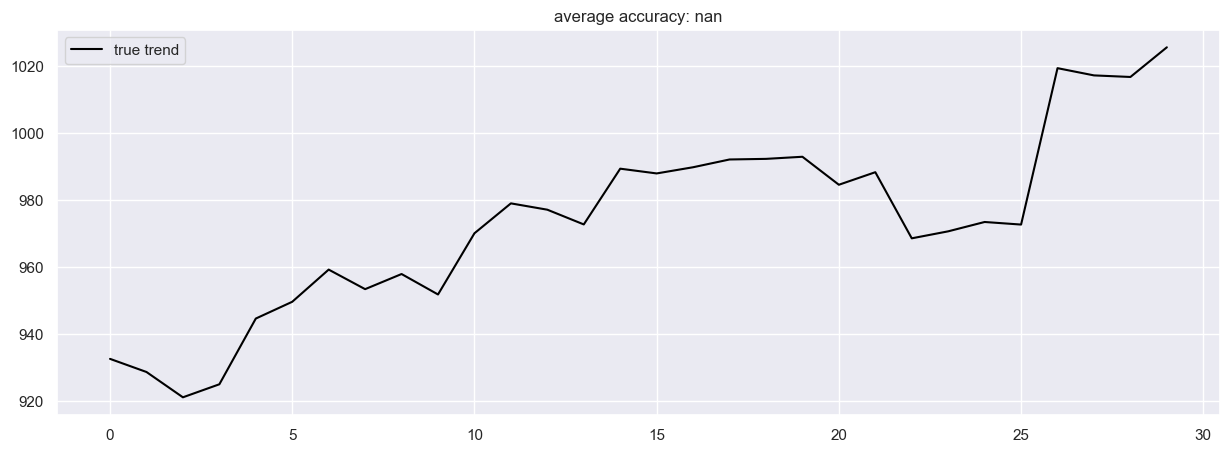

In [39]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()